# Brazilian E-Commerce Public Dataset by Olist

In [1]:
#Loading libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('fivethirtyeight')

In [2]:
#Reading all .csv files:

orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=True)
customers = pd.read_csv('olist_customers_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=True)
payments = pd.read_csv('olist_order_payments_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv', parse_dates=True)

## Data cleaning and type conversion

### Orders

In [3]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

There are a few missing values for some features, but since they won't be interefering in our analysis because they represent less than 3% of the entire dataset, we'll leave them as they are. In the future, we can calculate them accordingly to the other information we have.

There are five columns on the `Orders` dataset containing information about time, but they've not been converted to a datetime type yet. Let's do so.

In [6]:
time_orders = ['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date',
                      'order_delivered_customer_date','order_estimated_delivery_date']

orders[time_orders] = orders[time_orders].astype('datetime64[ns]')

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


Now that these columns are converted to the correct type, we can use them to:
 - Calculate how long it takes for an order to be approved, handled to the logistic partner and delivered to the customer;
 - Check if orders were delivered before or after the estimated time.

Since we'll be using the `'order_purchase_timestamp'` information to understand customer behaviour, we'll split this column into five different columns (hour, day, month, year and day of the week). There's no need to convert these values to datetime, so we'll keep them as strings.

In [8]:
#Time (hour)
orders['order_purchase_hour'] = pd.to_datetime(orders['order_purchase_timestamp']).apply(lambda time: time.hour)

#Day
orders['order_purchase_day'] = pd.to_datetime(orders['order_purchase_timestamp']).apply(lambda time: time.day)

#Month
orders['order_purchase_month'] = pd.to_datetime(orders['order_purchase_timestamp']).apply(lambda time: time.month)

#Year
orders['order_purchase_year'] = pd.to_datetime(orders['order_purchase_timestamp']).apply(lambda time: time.year)

#Day of the week
orders['order_purchase_dayofweek'] = pd.to_datetime(orders['order_purchase_timestamp']).apply(lambda x: x.strftime('%A'))

# orders_2016 = orders[orders['order_purchase_year'] == 2016]
# orders_2017 = orders[orders['order_purchase_year'] == 2017]
# orders_2018 = orders[orders['order_purchase_year'] == 2018]

### Customers

In [9]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [10]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


We won't be using the zip code prefixes for any calculation, so we can convert them to a string (object) type, instead of an integer. Also, there doesn't seem to be any missing values in this dataset.

In [11]:
customers['customer_zip_code_prefix'] = customers['customer_zip_code_prefix'].astype(str)

### Sellers

In [12]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [13]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


Again, let's convert the zip code column to string type. No missing values here too.

In [14]:
sellers['seller_zip_code_prefix'] = sellers['seller_zip_code_prefix'].astype(str)

### Items

In [15]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


As in the `Orders` dataset, we have a column containing date information. We'll convert it to a datetime type. This column (`shipping_limit_date`) shows the seller shipping limit date for handling the order over to the logistic partner. With this, we can check if they're shipping within the limit the date or not.

In [17]:
items['shipping_limit_date'] = items['shipping_limit_date'].astype('datetime64[ns]')

### Payments

In [18]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [19]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


The `Payments` dataset is clean. Nothing to be done here.

### Products

In [20]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [21]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [22]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

There are missing values for some information about our products, but since they represent less than 2% of our dataset and will not have a huge impact in our analysis, there is no need to drop or calculate them.

### Reviews

In [23]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [24]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Here we have lots of missing data for both the `'review_comment_title'` and the `'review_comment_message'` columns (they represent 88% and 58% of our dataset, respectively). Since the missing data can be important for a further analysis of why some customers didn't write a review, we'll not change these values for now.

Two columns containing time information need to be converted.

In [25]:
reviews[['review_creation_date', 'review_answer_timestamp']] = reviews[
    ['review_creation_date', 'review_answer_timestamp']].astype('datetime64[ns]')

## Exploratory Data Analysis

In [26]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_hour,order_purchase_day,order_purchase_month,order_purchase_year,order_purchase_dayofweek
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,10,2,10,2017,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,20,24,7,2018,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,8,8,8,2018,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,19,18,11,2017,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,21,13,2,2018,Tuesday


First we'll analyze when sales generally occur in order to understand our customers behavior. 
 - At what time of day do they usually buy?
 - Do they spend more at the beginning, the middle or the end of the month? What about days of the week?
 - Which month is the busiest?

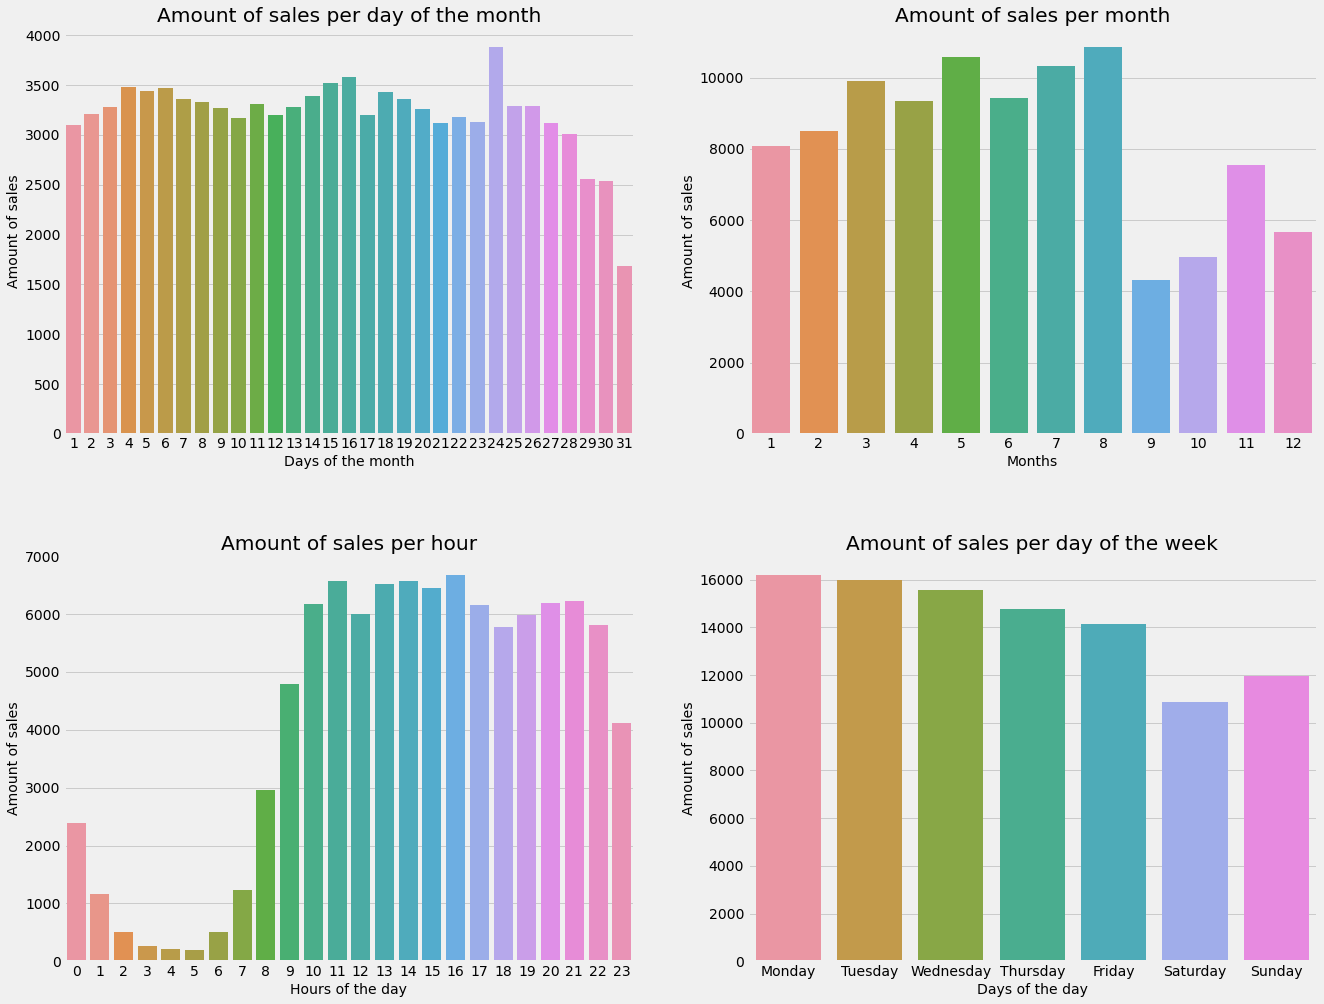

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(20,16))
plt.subplots_adjust(hspace = 0.3)

sns.countplot(orders['order_purchase_day'],ax=axes[0,0])

axes[0,0].set_title('Amount of sales per day of the month')
axes[0,0].set_xlabel('Days of the month', size=14)
axes[0,0].set_ylabel('Amount of sales', size=14)

sns.countplot(orders['order_purchase_month'],ax=axes[0,1])

axes[0,1].set_title('Amount of sales per month')
axes[0,1].set_xlabel('Months', size=14)
axes[0,1].set_ylabel('Amount of sales', size=14)

sns.countplot(orders['order_purchase_hour'], ax=axes[1,0])

axes[1,0].set_title('Amount of sales per hour')
axes[1,0].set_xlabel('Hours of the day', size=14)
axes[1,0].set_ylabel('Amount of sales', size=14)

sns.countplot(orders['order_purchase_dayofweek'], order=['Monday','Tuesday','Wednesday','Thursday','Friday',
                                                         'Saturday','Sunday'], ax=axes[1,1])

axes[1,1].set_title('Amount of sales per day of the week')
axes[1,1].set_xlabel('Days of the day', size=14)
axes[1,1].set_ylabel('Amount of sales', size=14)

plt.show()

In [28]:
sales_day_month = pd.DataFrame(pd.pivot_table(orders, index=['order_purchase_month','order_purchase_day'],
                                              aggfunc='count')['order_id']).reset_index()

sales_day_month.rename(columns={'order_id':'sales_count'}, inplace=True)

month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

sales_day_month['order_purchase_month'] = sales_day_month['order_purchase_month'].map(month_names)

In [29]:
sales_day_month.head()

,order_purchase_month,order_purchase_day,sales_count
0,January,1,74
1,January,2,204
2,January,3,225
3,January,4,258
4,January,5,242


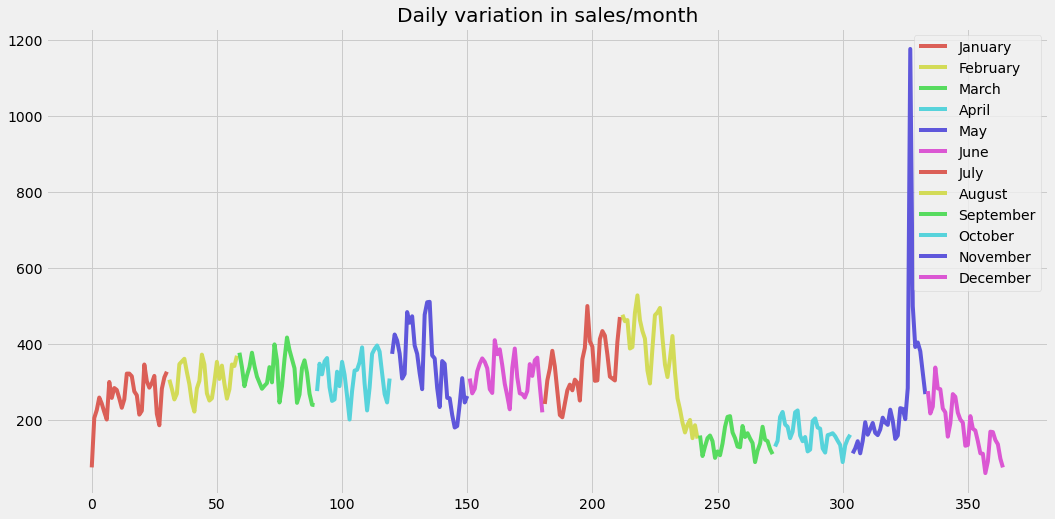

In [35]:
plt.figure(figsize=(16,8))
sns.set_palette('hls')

for month in sales_day_month['order_purchase_month'].unique():
    sns.lineplot(data=sales_day_month[sales_day_month['order_purchase_month']==month]['sales_count'], legend='full')
    
plt.legend(sales_day_month['order_purchase_month'].unique())
plt.title('Daily variation in sales/month');

We can definetely see a peak in sales during the end of November because of the **Black Friday**.

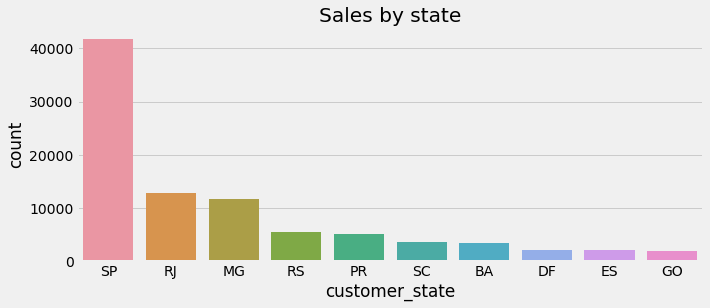

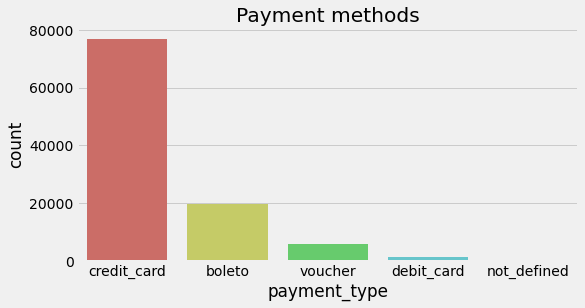

In [40]:
plt.figure(figsize=(10, 4))
sns.countplot(data=customers, 
              x='customer_state', 
              order=customers['customer_state'].value_counts().head(10).index)
plt.title('Sales by state');

plt.figure(figsize=(8, 4))
sns.countplot(data=payments, 
              x='payment_type', 
              order=payments['payment_type'].value_counts().index)
plt.title('Payment methods');

* São Paulo accounts for highest number of sales, followed by Rio de Janeiro and Minas Gerais.
 
* The most common payment method is credit card, chosen more than 70000 times.

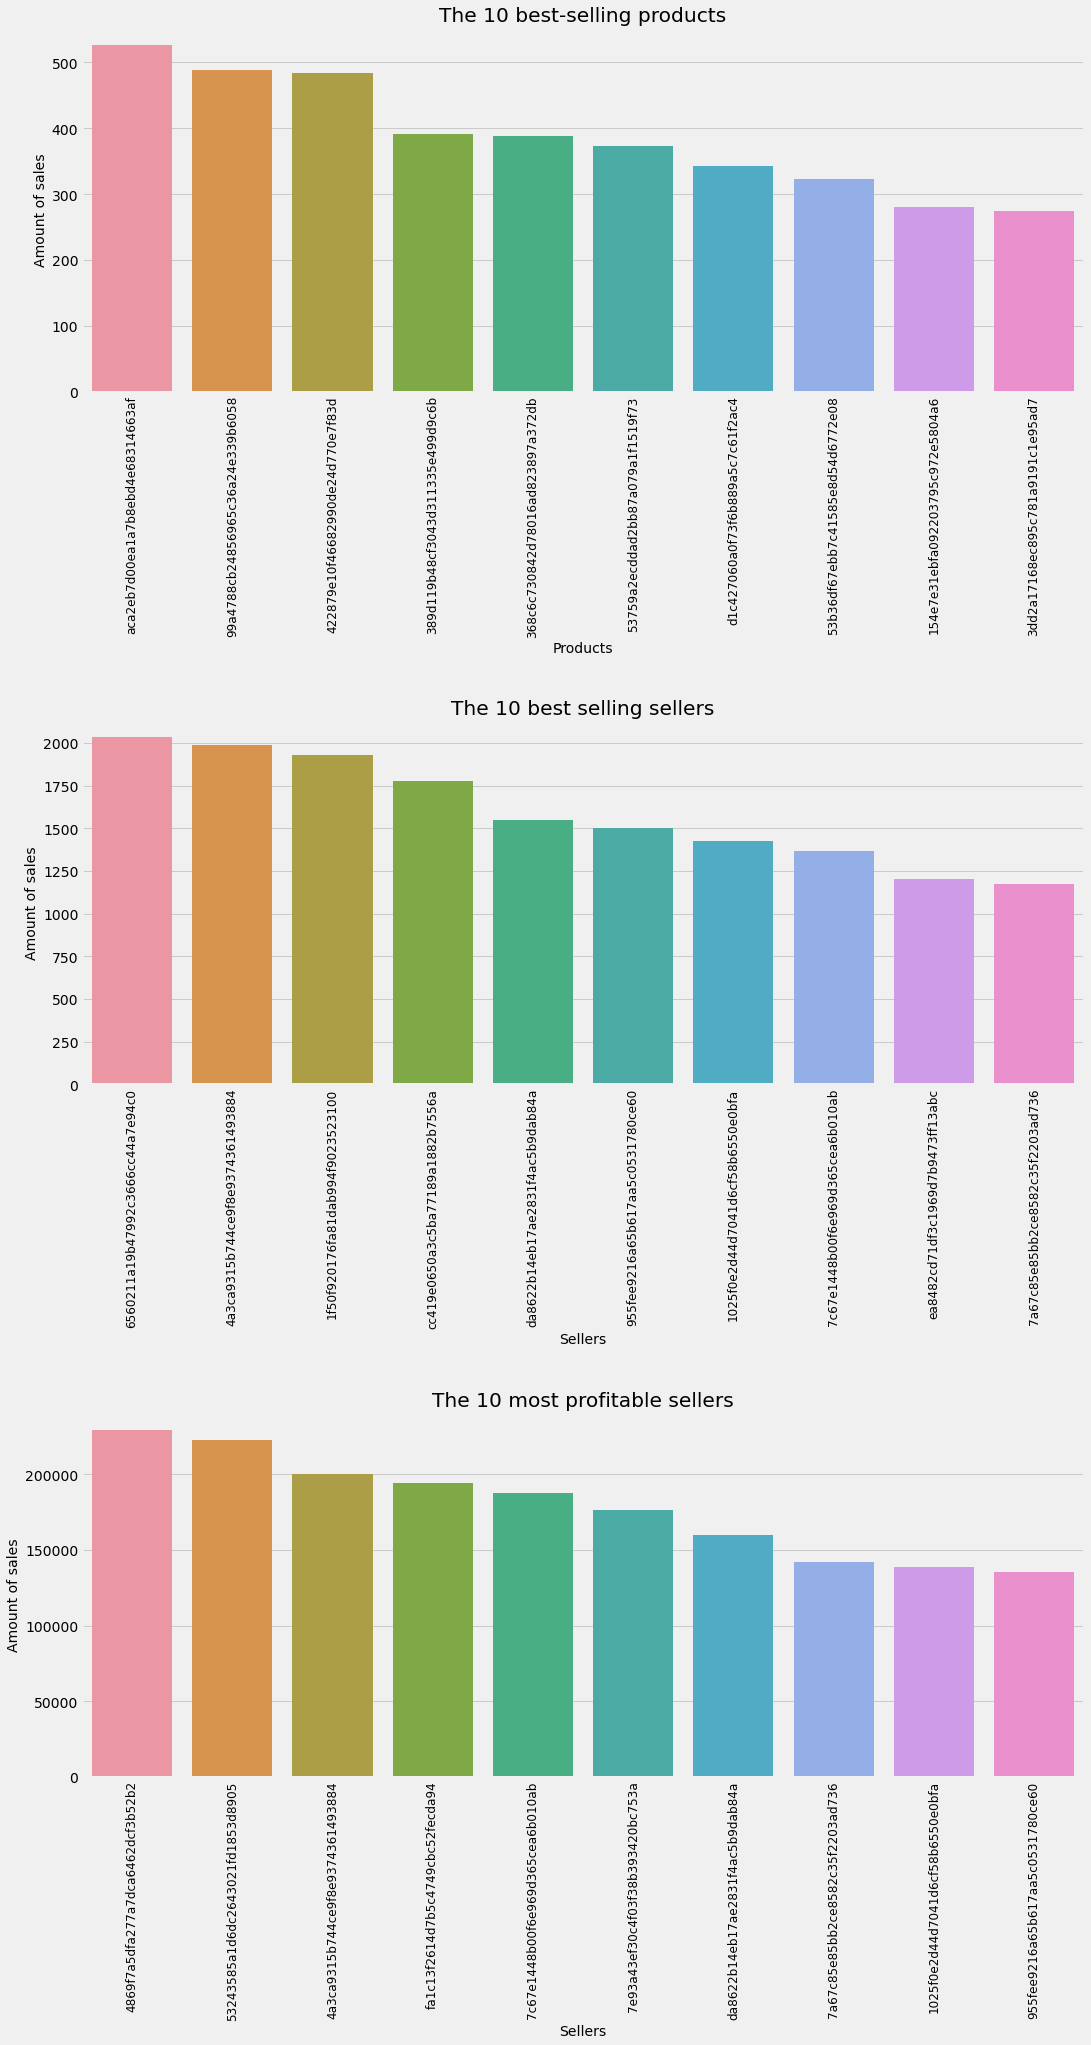

In [94]:
fig, axes = plt.subplots(3, 1, figsize=(16,30))
plt.subplots_adjust(hspace = 0.9)

sns.countplot(items['product_id'],
              order=items['product_id'].value_counts().iloc[:10].index,
              ax=axes[0])

axes[0].set_title('The 10 best-selling products')
axes[0].set_xlabel('Products', size=14)
axes[0].set_ylabel('Amount of sales', size=14)
axes[0].set_xticklabels(labels=items['product_id'].value_counts().iloc[:10].index, rotation=90, size=12)

sns.countplot(items['seller_id'],
              order=items['seller_id'].value_counts().iloc[:10].index,
              ax=axes[1])

axes[1].set_title('The 10 best selling sellers')
axes[1].set_xlabel('Sellers', size=14)
axes[1].set_ylabel('Amount of sales', size=14)
axes[1].set_xticklabels(labels=items['seller_id'].value_counts().iloc[:10].index, rotation=90, size=12)

sns.barplot(data=items,
            x=items.groupby('seller_id')['price'].sum().sort_values(ascending=False).iloc[:10].index,
            y=items.groupby('seller_id')['price'].sum().sort_values(ascending=False).iloc[:10].values,
            ax=axes[2])

axes[2].set_title('The 10 most profitable sellers')
axes[2].set_xlabel('Sellers', size=14)
axes[2].set_ylabel('Amount of sales', size=14)
axes[2].set_xticklabels(labels=items.groupby('seller_id')['price'].sum().sort_values(ascending=False).iloc[:10].index,
                        rotation=90, size=12)

plt.show()

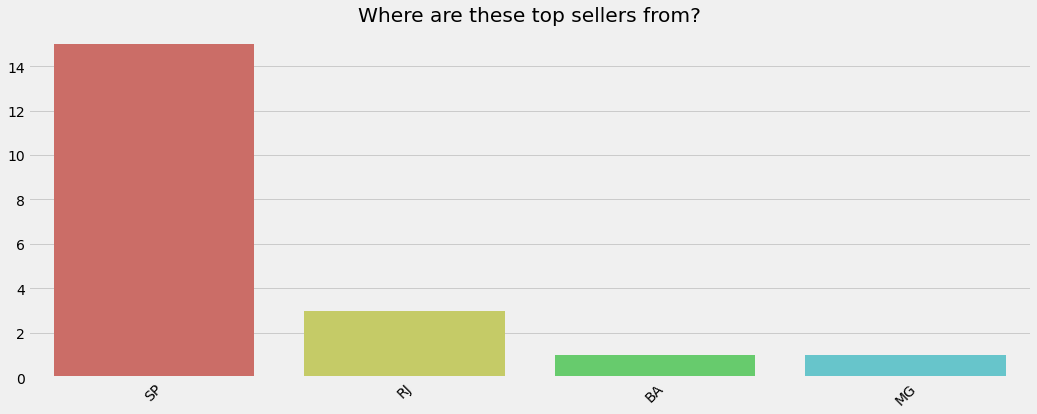

In [78]:
top_profit_sellers = items.groupby('seller_id')['price'].sum().sort_values(ascending=False).iloc[:20]
top_profit_sellers = sellers[sellers['seller_id'].isin(top_profit_sellers.index)]

plt.figure(figsize=(16,6))
sns.countplot(data=top_profit_sellers,
              x='seller_state',
              order=top_profit_sellers['seller_state'].value_counts().index)
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel(None)
plt.title('Where are these top sellers from?');

In [8]:
print('Correlation between sold quantity and profit:', items['seller_id'].value_counts().corr(items.groupby('seller_id')['price'].sum().sort_values(ascending=False)))

Correlation between sold quantity and profit: 0.7959552730213908


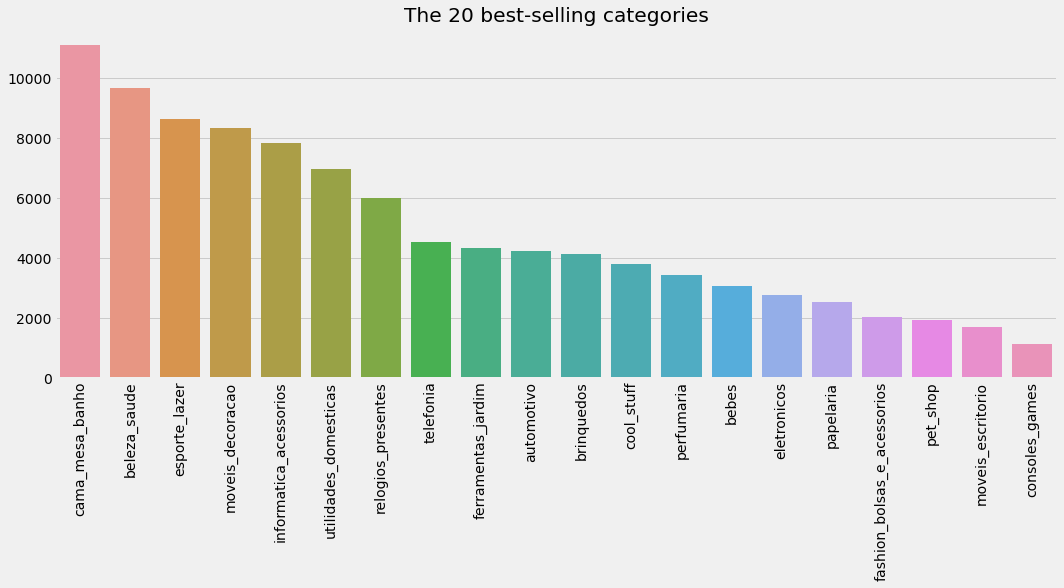

In [95]:
#Merging all sold products and their categories
categories = pd.merge(items['product_id'], products[['product_id','product_category_name']], on='product_id', how='inner')

plt.figure(figsize=(16,6))
sns.countplot(data=categories,
              x='product_category_name',
              order=categories['product_category_name'].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.title('The 20 best-selling categories');

* The category with the highest number of sales is "Bad, Bath and Table", followed by "Beauty and Health" and "Sport and Leisure"

In [97]:
#Creating a dataset containing sales seasonality per month, by category.
seasonality = orders.merge(items, on='order_id', how='left').merge(products, on='product_id', how='left')[[
    'order_id','order_purchase_month','product_category_name']]

seasonality = pd.DataFrame(pd.pivot_table(seasonality, index=['order_purchase_month','product_category_name'],
                                          aggfunc='count')['order_id']).reset_index()
seasonality['order_purchase_month'] = seasonality['order_purchase_month'].map(month_names)

seasonality.head()

,order_purchase_month,product_category_name,order_id
0,January,agro_industria_e_comercio,21
1,January,alimentos,22
2,January,alimentos_bebidas,11
3,January,artes,19
4,January,artigos_de_festas,2


In [98]:
#Comparing the top 10 best-selling categories monthly
list_sales_cat = []
for i in categories['product_category_name'].value_counts().iloc[:10].index:
    list_sales_cat.append(seasonality[seasonality['product_category_name'] == i]['order_id'].values)

In [99]:
season_top_categories = pd.DataFrame(index=categories['product_category_name'].value_counts().iloc[:10].index,
                                    columns=seasonality['order_purchase_month'].unique(),
                                    data=list_sales_cat)

season_top_categories

,January,February,March,April,May,June,July,August,September,October,November,December
cama_mesa_banho,896,855,1087,1020,1116,1155,1203,1170,533,553,975,552
beleza_saude,713,834,884,883,1060,1145,1100,1209,383,409,584,466
esporte_lazer,734,807,960,818,808,703,855,900,461,490,612,493
moveis_decoracao,794,700,923,797,884,638,760,869,350,446,783,390
informatica_acessorios,738,1087,932,680,784,669,753,769,253,343,532,287
utilidades_domesticas,387,481,611,654,926,915,853,917,255,247,423,295
relogios_presentes,381,374,511,602,771,605,696,628,268,319,469,367
telefonia,398,470,516,429,480,379,369,413,178,263,383,267
ferramentas_jardim,298,368,412,407,432,299,369,376,225,286,550,325
automotivo,302,405,431,444,436,412,461,543,108,162,263,268


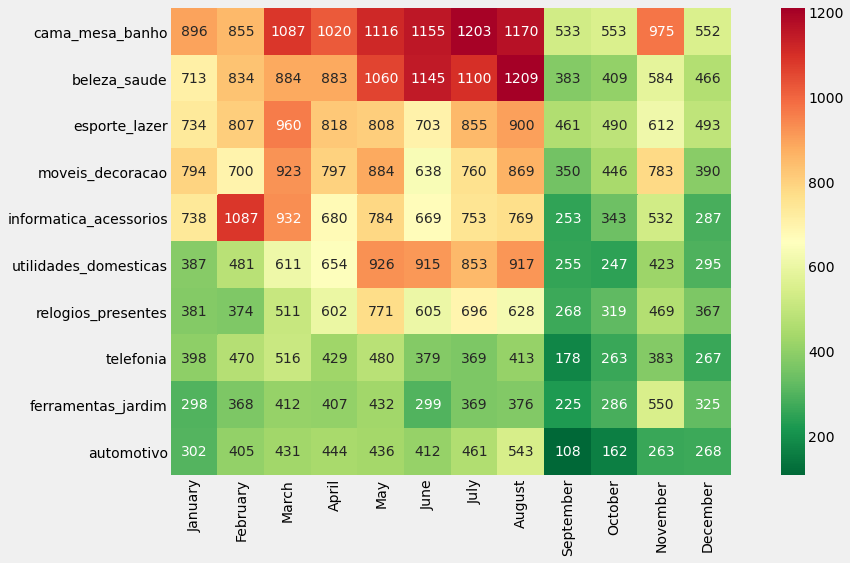

In [100]:
plt.figure(figsize=(16,8))
sns.heatmap(season_top_categories, square=True, annot=True, fmt='d', cmap='RdYlGn_r');